In [1]:
%run tools.ipynb

### play with NN model

In [2]:
# --- import necessary libraries

from xenonpy.model import Layer1d
from torch.nn import Sequential
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
from xenonpy.model.training import Trainer, SGD, MSELoss
from xenonpy.model.utils import regression_metrics
from xenonpy.model.training.extension import TensorConverter, Validator

In [4]:
x = np.linspace(-1, 1, 100)
y = np.power(x, 2) + 0.2 * np.random.rand(x.size)

x_val = np.linspace(-1, 1, 100)
y_val = np.power(x_val, 2) + 0.2 * np.random.rand(x_val.size)

In [5]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [6]:
torch.manual_seed(1)

trainer = Trainer(
    model=Net(n_feature=1, n_hidden=10, n_output=1),
    optimizer=SGD(),
    loss_func=MSELoss(),
    epochs=100
)

trainer.extend(
    TensorConverter(),
    Validator(
        x_val=x_val,
        y_val=y_val,
        metrics_func=regression_metrics),
)
trainer

Trainer(cuda=None, epochs=100, loss_func=MSELoss(), lr_scheduler=None,
        model=Net(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=1, bias=True)
),
        model_modifier=None,
        optimizer=SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
),
        verbose=True)

In [50]:
trainer.fit(x, y, epochs=10, save_training_state=True)

Training: 100%|██████████| 10/10 [00:00<00:00, 295.34it/s]


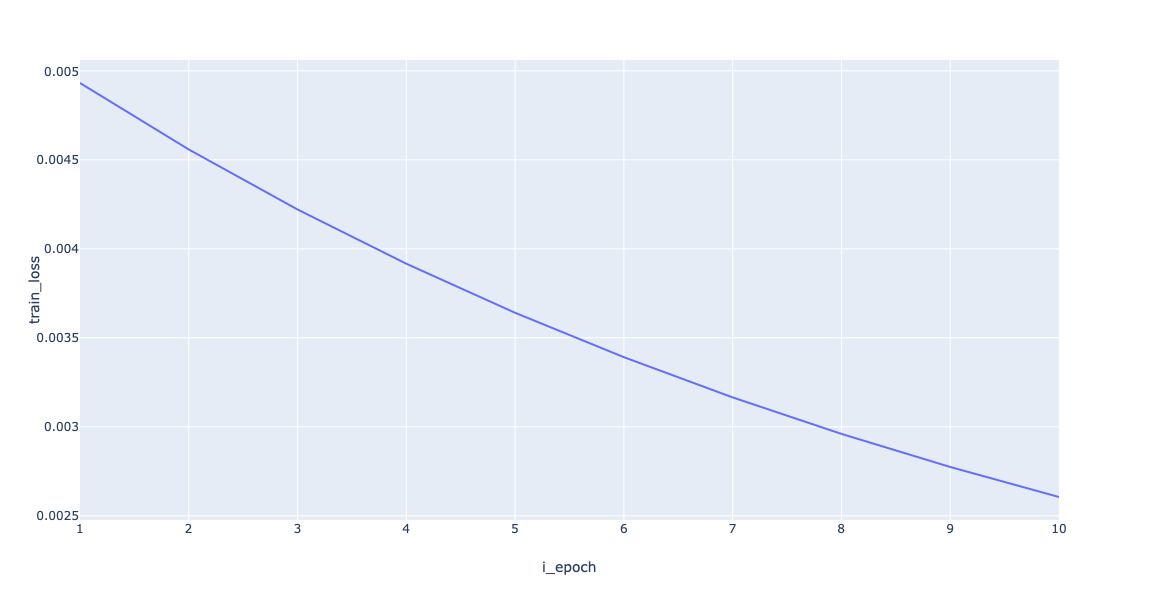

In [51]:
fig = px.line(trainer.step_info, x='i_epoch', y='train_loss')
fig.show()


In [49]:
trainer.reset()

# Model training

In [4]:
from xenonpy.model.training import Trainer, SGD, MSELoss, Adam, ReduceLROnPlateau, ExponentialLR
from xenonpy.model.training.extension import Validator, TensorConverter
from xenonpy.datatools import preset, Splitter
from xenonpy.descriptor import Compositions

In [5]:
# --- build nn regression model

def Net(n_feature, n_hidden1, n_hidden2, n_hidden3, n_output):
    return Sequential(
        Layer1d(n_in=n_feature, n_out=n_hidden1), 
        Layer1d(n_in=n_hidden1, n_out=n_hidden2),
        Layer1d(n_in=n_hidden2, n_out=n_hidden3),
        Layer1d(n_in=n_hidden3, n_out=n_output, act_func=None, batch_nor=None)
    ) 

In [6]:
data = preset.mp_inorganic
data = data.sample(3000)
data.head(5)

,band_gap,composition,density,e_above_hull,efermi,elements,final_energy_per_atom,formation_energy_per_atom,has_bandstructure,is_hubbard,is_ordered,n_elemets,nsites,oxide_type,point_group,pretty_formula,space_group,space_group_number,total_magnetization,volume
mp-1183509,0.0000,"{'Ca': 3.0, 'Pm': 1.0}",2.828054,0.100302,NaN,"[Ca, Pm]",-2.588686,0.100302,False,False,True,2,4,None,m-3m,Ca3Pm,Fm-3m,225,0.621093,155.736553
mp-1177991,0.8260,"{'Li': 32.0, 'Mn': 5.0, 'Cr': 11.0, 'O': 48.0}",3.622171,0.015253,NaN,"[Cr, Li, Mn, O]",-6.237396,-2.221736,False,True,True,4,96,oxide,1,Li32Mn5Cr11O48,P1,1,37.048391,842.026234
mp-1216393,0.0000,"{'Zn': 3.0, 'Fe': 2.0, 'Cu': 10.0, 'Sn': 5.0, ...",5.408977,0.023284,NaN,"[Cu, Fe, Se, Sn, Zn]",-4.122414,-0.333213,False,False,True,5,40,None,2,Zn3Fe2Cu10(SnSe4)5,C2,5,7.809951,956.641239
mp-780649,0.7259,"{'V': 8.0, 'O': 12.0, 'F': 4.0}",4.211685,0.018237,3.028795,"[F, O, V]",-7.474759,-2.653173,True,True,True,3,24,oxide,1,V2O3F,P1,1,3.000124,266.336314
mp-1215492,0.0000,"{'Yb': 4.0, 'Sm': 1.0, 'S': 5.0}",7.355049,0.006992,NaN,"[S, Sm, Yb]",-5.352276,-2.536897,False,False,True,3,10,None,4/mmm,Yb4SmS5,I4/mmm,139,0.000008,226.410887


In [7]:
desc = Compositions(featurizers='classic').transform(data['composition']).astype('float32')
prop = data['volume'].to_frame().astype('float32')

desc.head(5)
prop.head(5)

,ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,ave:atomic_weight,ave:boiling_point,ave:bulk_modulus,ave:c6_gb,ave:covalent_radius_cordero,ave:covalent_radius_pyykko,...,min:num_s_valence,min:period,min:specific_heat,min:thermal_conductivity,min:vdw_radius,min:vdw_radius_alvarez,min:vdw_radius_mm3,min:vdw_radius_uff,min:sound_velocity,min:Polarizability
mp-1183509,30.250000,193.452194,273.250000,28.721176,66.286690,2067.750000,21.000000,2507.500000,181.750000,171.500000,...,2.0,4.0,0.185,15.00000,231.0,262.0,272.0,339.899994,3810.0,25.000
mp-1177991,9.052083,146.694458,198.135422,12.580000,19.132076,871.665833,66.303017,592.662476,99.406250,96.010414,...,1.0,2.0,0.477,0.02658,152.0,150.0,182.0,245.100006,317.5,0.802
mp-1216393,34.049999,138.899994,225.199997,13.107500,77.906502,1746.574951,60.150002,319.975006,126.625000,118.150002,...,1.0,4.0,0.222,0.52000,190.0,182.0,223.0,276.299988,2500.0,3.770
mp-780649,13.166667,140.104645,196.666672,12.633333,28.146400,1275.930054,99.186180,328.383331,93.500000,86.833336,...,2.0,2.0,0.485,0.02658,147.0,146.0,171.0,314.399994,317.5,0.557
mp-1215492,42.200001,159.199997,245.800003,19.660000,100.283997,1151.712036,20.049999,1147.000000,147.100006,136.699997,...,2.0,3.0,0.145,0.20500,180.0,189.0,215.0,335.500000,1590.0,2.900


,volume
mp-1183509,155.736557
mp-1177991,842.026245
mp-1216393,956.641235
mp-780649,266.336304
mp-1215492,226.410889


In [8]:
sp = Splitter(3000)
x_train, x_test, y_train, y_test = sp.split(desc, prop)

In [9]:
x_train.shape
y_train.shape
x_test.shape
y_test.shape

(2400, 290)

(2400, 1)

(600, 290)

(600, 1)

In [28]:
# --- check model
nn_model = Net(
    n_feature=290,
    n_hidden1=200,
    n_hidden2=100,
    n_hidden3=30,
    n_output=1)

nn_model

Sequential(
  (0): Layer1d(
    (layer): Linear(in_features=290, out_features=200, bias=True)
    (batch_nor): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
  )
  (1): Layer1d(
    (layer): Linear(in_features=200, out_features=100, bias=True)
    (batch_nor): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
  )
  (2): Layer1d(
    (layer): Linear(in_features=100, out_features=30, bias=True)
    (batch_nor): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
  )
  (3): Layer1d(
    (layer): Linear(in_features=30, out_features=1, bias=True)
  )
)

In [29]:
trainer = Trainer(
    model=nn_model,
#     optimizer=SGD(lr=0.001, momentum=0.8, dampening=0.7, weight_decay=0.1),
    optimizer=Adam(lr=0.01, weight_decay=0.1),
    loss_func=MSELoss(),
#     lr_scheduler=ReduceLROnPlateau(),
    epochs=1000,
)

In [30]:
trainer.extend(
    TensorConverter(),
    Validator(x_test, y_test,
        metrics_func=regression_metrics),
)

In [31]:
from torch.utils.data import DataLoader, TensorDataset

In [32]:
dataloader = DataLoader(
    TensorDataset(
        torch.from_numpy(x_train),
        torch.from_numpy(y_train)),
    shuffle=True,
    batch_size=200
)

In [ ]:
trainer.fit(x_train=x_train, y_train=y_train, epochs=10)

Training:  30%|███       | 3/10 [00:00<00:00, 25.55it/s]

In [25]:
trainer.fit(training_dataset=dataloader, epochs=100)

Training: 100%|██████████| 100/100 [00:09<00:00, 10.87it/s]


In [26]:
trainer.timer

Total elapsed: 0:00:09.433292 <seconds>
  |- fit: 0:00:09.414722
  |- _step_forward: 0:00:00.007380
  |- input_proc: 0:00:00.006016
  |- output_proc: 0:00:00.005166
  |- _before_proc: 0:00:00.000005
  |- _after_proc: 0:00:00.000003

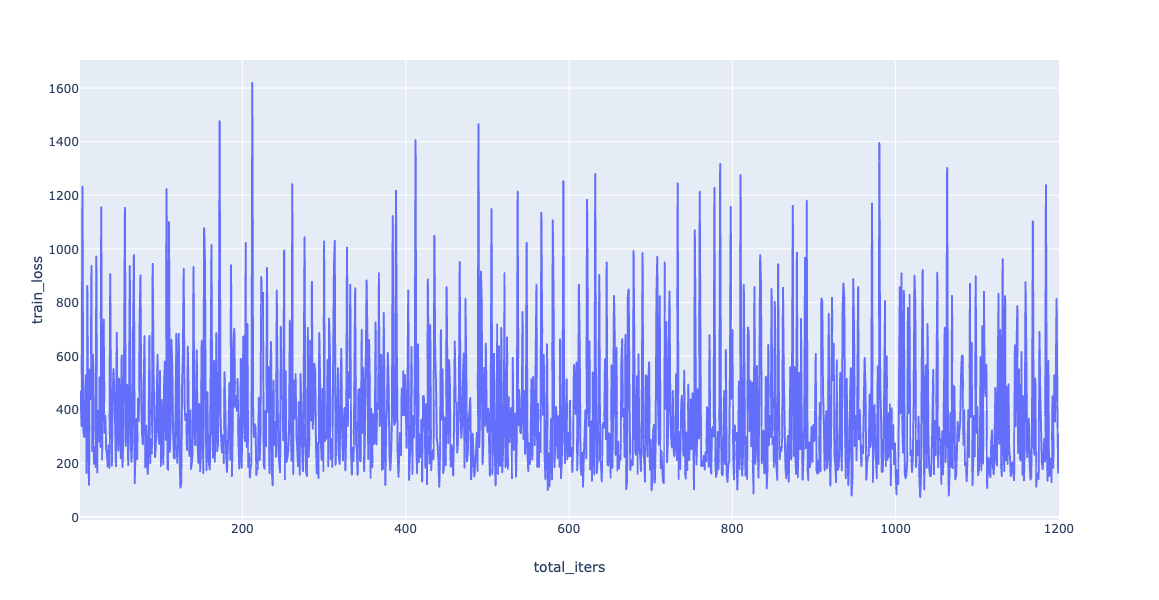

In [27]:
fig = px.line(trainer.step_info, x='total_iters', y='train_loss')
fig.show()


# Model testing

In [21]:
y_pred = trainer.predict(x_test)

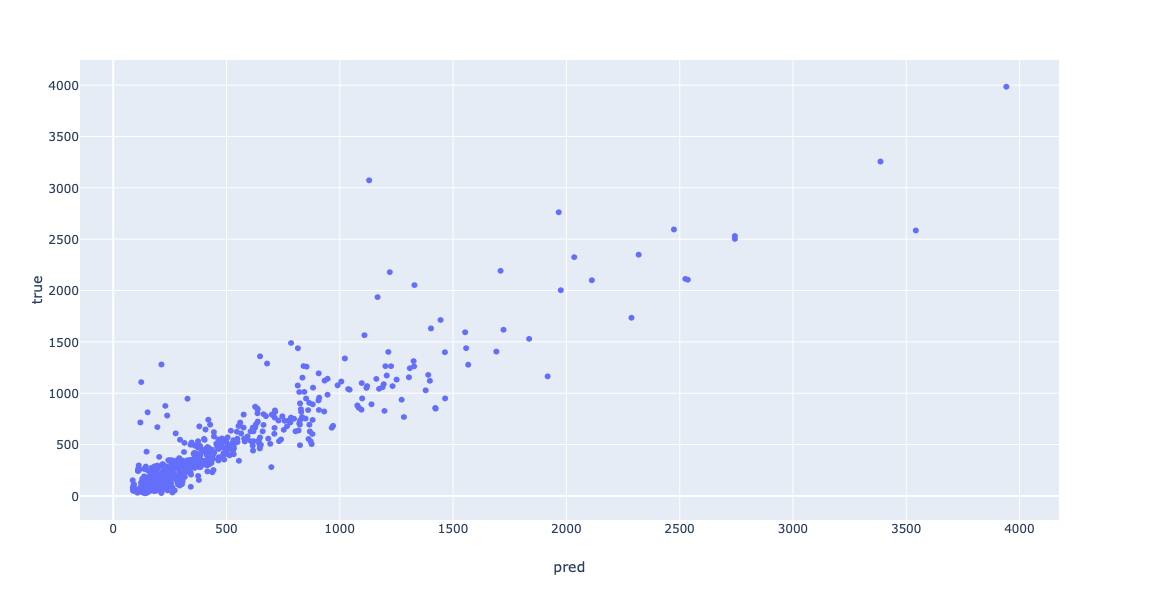

In [22]:
fig = px.scatter(pd.DataFrame({'pred': y_pred.flatten(), 'true': y_test.flatten()}), x='pred', y='true')
fig.show()

### model building with random hyper parameters

In [25]:
# --- import necessary libraries

from xenonpy.model.nn import Generator1d
from xenonpy.model.nn import wrap

# 3rd packages
from torch.nn import ReLU, Tanh
from math import ceil

In [26]:
# parameter scheduler
def scheduler(i, paras):
    n_out = max(ceil(paras['n_out'] * uniform(0.3, 0.8)),5)
    return dict(paras, n_out=n_out)

# model generator
generator = Generator1d(290, 1,  # num of input an output neuron
                n_neuron=[ceil(uniform(0.8, 1.0) * 150) for n in range(5)],  # variety of neuron num in each layer
                act_func=(ReLU(),),   # variety of activation function in each layer
                drop_out=(0.1,),  # variety of dropout rate in each layer
                batch_normalize=(wrap.L1.batch_norm(),)
               )

In [30]:
# --- generate models

models = generator(4, n_models=1, replace=True, scheduler=scheduler)

In [31]:
# --- check the model generator

models

<generator object Generator1d.__call__ at 0x1a48e97ca8>

In [32]:
model = list(models)[0]
model

Sequential(
  (0): Layer1d(
    (layer): Linear(in_features=290, out_features=125, bias=True)
    (batch_nor): BatchNorm1d(125, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
    (dropout): Dropout(p=0.1)
  )
  (1): Layer1d(
    (layer): Linear(in_features=125, out_features=69, bias=True)
    (batch_nor): BatchNorm1d(69, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
    (dropout): Dropout(p=0.1)
  )
  (2): Layer1d(
    (layer): Linear(in_features=69, out_features=38, bias=True)
    (batch_nor): BatchNorm1d(38, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
    (dropout): Dropout(p=0.1)
  )
  (3): Layer1d(
    (layer): Linear(in_features=38, out_features=16, bias=True)
    (batch_nor): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
    (dropout): Dropout(p=0.1)
  )
  (4): Linear(in_features=16, out_features=1, bi